In [1]:
import os, math

import numpy as np
import matplotlib.pyplot as plt

import pydicom
import SimpleITK as sitk

In [2]:
study_dir = "../Data/Head-Neck-PET-CT/HN-CHUM-001/08-27-1885-PANC. avec C.A. SPHRE ORL   tte et cou  -TP-74220/"

## General utility functions

In [176]:
def read_dicom_slices(series_dir):
    # Uses Pydicom
    print("Loading DICOM series ...")
    
    file_names = sorted(os.listdir(series_dir))
    dicom_files = [pydicom.dcmread(series_dir + fn) for fn in file_names]

    dicom_slices = []
    n_skipped = 0
    for f in dicom_files:
        if hasattr(f, 'SliceLocation'): # Only take the slice if slice location attribute exists
            dicom_slices.append(f)
        else:
            n_skipped += 1
    
    dicom_slices = sorted(dicom_slices, key=lambda sl: sl.SliceLocation) # Sort slices by slice location (starting from feet-side) 
    
    print("Total slices found:", len(dicom_files))
    print("Slices loaded:", len(dicom_slices))
    print("Slices skipped:", n_skipped)
    print("Pixel spacing:", dicom_slices[0].PixelSpacing)
    print("Slice thickness:", dicom_slices[0].SliceThickness)
    print("\n")
    
    return dicom_slices, n_skipped


def read_dcm_series(series_dir):
    """
    Read a DICOM series into a sitk image.
    Parameters
        series_dir: Directory containing a DICOM series
    Returns
        sitk_image: SimpleITK Image object
        meta: Python dictionary containing selected meta-data
    """
    if len(os.listdir(series_dir)) > 1:
        reader = sitk.ImageSeriesReader()
        dcm_file_paths = reader.GetGDCMSeriesFileNames(series_dir)
        sitk_image = sitk.ReadImage(dcm_file_paths)
        dicom_data = pydicom.read_file(dcm_file_paths[0], stop_before_pixels=True)
    else:
        file_name = os.listdir(series_dir)[0]
        #sitk_image = sitk.ReadImage(series_dir + file_name)
        sitk_image = None
        #print(file_name)
        dicom_data = pydicom.read_file(series_dir + file_name, stop_before_pixels=True)

    meta = {}

    meta['PatientID'] = dicom_data.PatientID
    meta['StudyID'] = dicom_data.StudyID
    meta['StudyInstanceUID'] = dicom_data.StudyInstanceUID
    meta['Modality'] = dicom_data.Modality

    if dicom_data.Modality in ['PT', 'CT']:
        # Using sitk to extract image mata-data
        meta['Spacing'] = sitk_image.GetSpacing()
        meta['Width'] = sitk_image.GetWidth()
        meta['Height'] = sitk_image.GetHeight()
        meta['Depth'] = sitk_image.GetDepth()
        meta['Direction'] = sitk_image.GetDirection()
        
    if dicom_data.Modality == 'RTSTRUCT':
        meta['StructureSetLabel'] = dicom_data.StructureSetLabel
        meta['StructureSetName'] = dicom_data.StructureSetName
    
    return sitk_image, meta


def get_series_dirs(patient_dir):
    patient_subdirs = sorted(os.listdir(patient_dir))
    series_dirs = []
    for subdir in patient_subdirs:
        series_dirs.extend( [ patient_dir+'/'+subdir+'/'+s+'/' for s in sorted(os.listdir(patient_dir+'/'+subdir)) ] )
    return series_dirs
    

#### CT tags --

'AcquisitionDate', 'AcquisitionNumber', 'AcquisitionTime', 'AdditionalPatientHistory', 'BitsAllocated', 'BitsStored', 'Columns', 'ContentDate', 'ContentTime', 'ConvolutionKernel', 'DataCollectionDiameter', 'DeidentificationMethod', 'DeidentificationMethodCodeSequence', 'DistanceSourceToDetector', 'DistanceSourceToPatient', 'Exposure', 'ExposureTime', 'FilterType', 'FocalSpots', 'FrameOfReferenceUID', 'GantryDetectorTilt', 'GeneratorPower', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'ImageType', 'InstanceCreationDate', 'InstanceCreationTime', 'InstanceNumber', 'KVP', 'LongitudinalTemporalInformationModified', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientIdentityRemoved', 'PatientName', 'PatientPosition', 'PatientSex', 'PatientSize', 'PatientWeight', 'PerformedProcedureStepDescription', 'PerformedProcedureStepStartDate', 'PerformedProcedureStepStartTime', 'PhotometricInterpretation', 'PixelData', 'PixelPaddingValue', 'PixelRepresentation', 'PixelSpacing', 'PositionReferenceIndicator', 'ProtocolName', 'ReconstructionDiameter', 'ReferencedImageSequence', 'ReferringPhysicianName', 'RescaleIntercept', 'RescaleSlope', 'RescaleType', 'RevolutionTime', 'RotationDirection', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'ScanOptions', 'SeriesDate', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SeriesTime', 'SingleCollimationWidth', 'SliceLocation', 'SliceThickness', 'SoftwareVersions', 'SpecificCharacterSet', 'SpiralPitchFactor', 'StudyDate', 'StudyDescription', 'StudyID', 'StudyInstanceUID', 'StudyStatusID', 'StudyTime', 'TableFeedPerRotation', 'TableHeight', 'TableSpeed', 'TotalCollimationWidth', 'WindowCenter', 'WindowWidth', 'XRayTubeCurr


#### PT tags --

'AcquisitionContextSequence', 'AcquisitionDate', 'AcquisitionStartCondition', 'AcquisitionStartConditionData', 'AcquisitionTerminationCondition', 'AcquisitionTerminationConditionData', 'AcquisitionTime', 'ActualFrameDuration', 'AdditionalPatientHistory', 'AttenuationCorrectionMethod', 'AxialMash', 'BitsAllocated', 'BitsStored', 'CoincidenceWindowWidth', 'CollimatorType', 'Columns', 'ContentDate', 'ContentTime', 'CorrectedImage', 'CountsSource', 'DeadTimeFactor', 'DecayCorrection', 'DecayFactor', 'DeidentificationMethod', 'DeidentificationMethodCodeSequence', 'DetectorLinesOfResponseUsed', 'DoseCalibrationFactor', 'EnergyWindowRangeSequence', 'FieldOfViewDimensions', 'FieldOfViewShape', 'FrameOfReferenceUID', 'FrameReferenceTime', 'FrameTime', 'GantryDetectorTilt', 'HighBit', 'ImageIndex', 'ImageOrientationPatient', 'ImagePositionPatient', 'ImageType', 'InstanceCreationDate', 'InstanceCreationTime', 'InstanceCreatorUID', 'InstanceNumber', 'IntervalsAcquired', 'IntervalsRejected', 'LargestImagePixelValue', 'LongitudinalTemporalInformationModified', 'LossyImageCompression', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'NumberOfSlices', 'PatientAge', 'PatientBirthDate', 'PatientGantryRelationshipCodeSequence', 'PatientID', 'PatientIdentityRemoved', 'PatientName', 'PatientOrientationCodeSequence', 'PatientOrientationModifierCodeSequence', 'PatientPosition', 'PatientSex', 'PatientSize', 'PatientWeight', 'PhotometricInterpretation', 'PixelData', 'PixelRepresentation', 'PixelSpacing', 'PositionReferenceIndicator', 'PrimaryPromptsCountsAccumulated', 'ProtocolName', 'RadiopharmaceuticalInformationSequence', 'RandomsCorrectionMethod', 'ReconstructionDiameter', 'ReconstructionMethod', 'ReferringPhysicianName', 'RescaleIntercept', 'RescaleSlope', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'ScatterCorrectionMethod', 'ScatterFractionFactor', 'SecondaryCountsAccumulated', 'SeriesDate', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SeriesTime', 'SeriesType', 'SliceLocation', 'SliceSensitivityFactor', 'SliceThickness', 'SmallestImagePixelValue', 'SoftwareVersions', 'SpecificCharacterSet', 'StudyDate', 'StudyDescription', 'StudyID', 'StudyInstanceUID', 'StudyStatusID', 'StudyTime', 'TransverseMash', 'TriggerTime', 'TypeOfDetectorMotion', 'Units'

#### RTSTRUCT tags --

'AccessionNumber', 'AcquisitionDate', 'ApprovalStatus', 'DeidentificationMethod', 
'DeidentificationMethodCodeSequence', 'FrameOfReferenceUID', 'InstanceCreationDate', 
'InstanceCreationTime', 'LongitudinalTemporalInformationModified', 'Manufacturer', 
'ManufacturerModelName', 'Modality', 'PatientAge', 'PatientBirthDate', 'PatientID', 
'PatientIdentityRemoved', 'PatientName', 'PatientSex', 'PatientSize', 'PatientWeight',
'ROIContourSequence', 'RTROIObservationsSequence', 'ReferencedFrameOfReferenceSequence',
'ReferringPhysicianName', 'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription', 
'SeriesInstanceUID', 'SeriesNumber', 'SeriesTime', 'SoftwareVersions', 'SpecificCharacterSet', 
'StructureSetDate', 'StructureSetLabel', 'StructureSetName', 'StructureSetROISequence', 
'StructureSetTime', 'StudyDate', 'StudyDescription', 'StudyID', 'StudyInstanceUID', 'StudyTime'



In [177]:
patient_dir = "../Data/Head-Neck-PET-CT/HN-CHUM-001"

series_dirs = get_series_dirs(patient_dir)
#print(series_dirs)

for series_dir in series_dirs:
    sitk_image, meta = read_dcm_series(series_dir)
    for k,v in meta.items():
        print(k, ":", v)
    print('\n')
    
    
    

PatientID : HN-CHUM-001
StudyID : 
StudyInstanceUID : 1.3.6.1.4.1.14519.5.2.1.5168.2407.301393959337245377111689674220
Modality : RTSTRUCT
StructureSetLabel : RTstruct
StructureSetName : RTstruct_CTsim->CT(PET-CT)


PatientID : HN-CHUM-001
StudyID : 
StudyInstanceUID : 1.3.6.1.4.1.14519.5.2.1.5168.2407.301393959337245377111689674220
Modality : RTSTRUCT
StructureSetLabel : RTstruct
StructureSetName : RTstruct_CTsim->PET(PET-CT)


PatientID : HN-CHUM-001
StudyID : 
StudyInstanceUID : 1.3.6.1.4.1.14519.5.2.1.5168.2407.301393959337245377111689674220
Modality : CT
Spacing : (0.976562, 0.976562, 3.269989013671875)
Width : 512
Height : 512
Depth : 90
Direction : (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


PatientID : HN-CHUM-001
StudyID : 
StudyInstanceUID : 1.3.6.1.4.1.14519.5.2.1.5168.2407.301393959337245377111689674220
Modality : PT
Spacing : (3.515625, 3.515625, 3.269989013671875)
Width : 128
Height : 128
Depth : 91
Direction : (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


PatientID

# CT data

## Pydicom style

In [33]:
# CT specific functions using Pydicom

def get_ct_image3d(dicom_slices):
    """
    Input --
    dicom_slices: List of pydicom objects (each is a slice)
    ------
    Output --
    ct_image3d: Numpy array of shape (rows, columns, slices) 
    """
    ct_img_shape = list(dicom_slices[0].pixel_array.shape)
    ct_img_shape.append(len(dicom_slices))
    ct_image3d = np.zeros(ct_img_shape)
    
    # Need to manually rescale the pixel values using the slope and intercept meta data 
    rescale_slope = dicom_slices[0].RescaleSlope
    rescale_intercept = dicom_slices[0].RescaleIntercept
    
    for i, sl in enumerate(dicom_slices):
        image2d = sl.pixel_array
        # image2d[image2d == -2000] = 0 # Set out-of-bound region values to 0 (to make it same as air) 
        image2d_hu = image2d * rescale_slope + rescale_intercept # Converting to HU
        ct_image3d[:,:,i] = image2d_hu
    
    print(f"HU range of the CT volume: ({int(ct_image3d.min())}, {int(ct_image3d.max())}) ")
    
    return ct_image3d


def apply_hu_window(ct_volume, window_level, window_width):
    ct_volume_win = ct_volume.copy()
    
    window_max = window_level + window_width // 2
    window_min = window_level - window_width // 2

    ct_volume_win[ct_volume_win > window_max] = window_max
    ct_volume_win[ct_volume_win < window_min] = window_min
    
    return ct_volume_win


Loading DICOM series ...
Total slices found: 90
Slices loaded: 90
Slices skipped: 0
Pixel spacing: [0.976562, 0.976562]
Slice thickness: 3.750000


HU range of the CT volume: (-1024, 1964) 


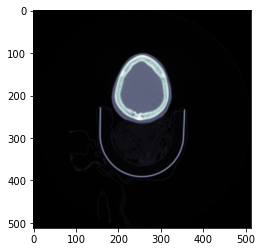

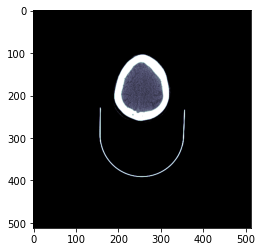

In [34]:
ct_series_dir = study_dir + "3.000000-StandardFull-07232/"

dicom_slices, n_skipped = read_dicom_slices(ct_series_dir) # Get a list of pydicom objects (each object contains a slice) 

# Convert to a 3d numpy array of pixel values
ct_image3d = get_ct_image3d(dicom_slices) 
plt.imshow(ct_image3d[:,:,80], cmap=plt.cm.bone)
plt.show()

# Apply HU window
ct_image3d_win = apply_hu_window(ct_image3d, window_level=100, window_width=300)
plt.imshow(ct_image3d_win[:,:,80], cmap=plt.cm.bone)
plt.show()

## SimpleITK style

### Reading DICOM series 

In [40]:
ct_series_dir = study_dir + "3.000000-StandardFull-07232/"

# Create a reader
reader = sitk.ImageSeriesReader()
# Use the functional interface to read the image series.
dcm_file_paths = reader.GetGDCMSeriesFileNames(ct_series_dir)
# Read the image
sitk_image = sitk.ReadImage(dcm_file_paths)  # Pixel values are rescaled automatically by SimpleITK

''' 
Note: SimpleITK does not include visualization feature. 
To visualize, it first stores the image as a temporary .nii file and then invokes a visualization tool 
'''

# Set environment variable to point to the 3D Slicer executable for visualization
%env SITK_SHOW_COMMAND "/home/chinmay/Desktop/Maastro Internship/Work/Tools/Slicer-4.10.2-linux-amd64/Slicer"

# Visualize 
print("Opening 3D Slicer")
#sitk.Show(sitk_image)

env: SITK_SHOW_COMMAND="/home/chinmay/Desktop/Maastro Internship/Work/Tools/Slicer-4.10.2-linux-amd64/Slicer"
Opening 3D Slicer


(90, 512, 512)


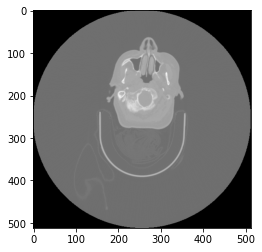

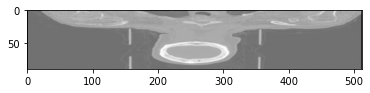

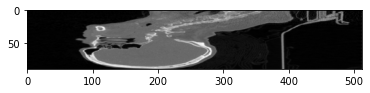

In [62]:
# Viewing the image array as it is

img_array = sitk.GetArrayFromImage(sitk_image)
print(img_array.shape)

# Axial
plt.imshow(img_array[45,:,:], cmap='gray')
plt.show()

# Coronal
plt.imshow(img_array[:,256,:], cmap='gray')
plt.show()

# Sagittal
plt.imshow(img_array[:,:,256], cmap='gray')
plt.show()


The original image has non-isotropic pixel spacing, but the np array has no spacing information and assumes the data to be isotropic. 


### Converting DICOM series to NRRD file

In [36]:
ct_series_dir = study_dir + "3.000000-StandardFull-07232/"

# Create a reader
reader = sitk.ImageSeriesReader()

# Read a DICOM series
dcm_file_paths = reader.GetGDCMSeriesFileNames(ct_series_dir)
sitk_image_1 = sitk.ReadImage(dcm_file_paths)

# Write the image into an NRRD file
ouput_nrrd_file = os.path.join("./", '3DImage.nrrd')
sitk.WriteImage(sitk_image_1, ouput_nrrd_file, True)

# Read it back again
sitk_image_2 = sitk.ReadImage(ouput_nrrd_file)

# Check that the original and written image are the same
statistics_image_filter = sitk.StatisticsImageFilter()
statistics_image_filter.Execute(sitk_image_1 - sitk_image_2)

# Check that the original and written files are the same
print('Max, Min differences are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))

Max, Min differences are : 0.0, 0.0


In [37]:
# Check some of the Meta data
'''
Note: SimpleITK cannot read the complete meta data of a DICOM series. Only the image properties are accesible easily. 
Use Pydicom to access ALL the meta data, if needed. 
Reference - https://discourse.slicer.org/t/simpleitk-fails-to-load-dicom-metadata/6822/2
'''

# For image read from DICOM series
print("Image 1 info --")
print("Size:", sitk_image_1.GetSize())
print("Origin:", sitk_image_1.GetOrigin())
print("Spacing:", sitk_image_1.GetSpacing())
print("Direction:",sitk_image_1.GetDirection())
print("Components per pixel:", sitk_image_1.GetNumberOfComponentsPerPixel())
print("Pixel ID value:", sitk_image_1.GetPixelIDValue())
print("Pixel ID Type:", sitk_image_1.GetPixelIDTypeAsString())


# For image read from NRRD file
print("\nImage 2 info --")
print("Size:", sitk_image_2.GetSize())
print("Origin:", sitk_image_2.GetOrigin())
print("Spacing:", sitk_image_2.GetSpacing())
print("Direction:", sitk_image_2.GetDirection())
print("Components per pixel:", sitk_image_2.GetNumberOfComponentsPerPixel())
print("Pixel ID value:", sitk_image_2.GetPixelIDValue())
print("Pixel ID Type:", sitk_image_2.GetPixelIDTypeAsString())


Image 1 info --
Size: (512, 512, 90)
Origin: (-250.0, -250.0, -278.29998779296875)
Spacing: (0.976562, 0.976562, 3.269989013671875)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Components per pixel: 1
Pixel ID value: 4
Pixel ID Type: 32-bit signed integer

Image 2 info --
Size: (512, 512, 90)
Origin: (-250.0, -250.0, -278.29998779296875)
Spacing: (0.976562, 0.976562, 3.269989013671875)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Components per pixel: 1
Pixel ID value: 4
Pixel ID Type: 32-bit signed integer


## Visualization

In [10]:
# Read data

ct_series_dir = study_dir + "3.000000-StandardFull-07232/"
reader = sitk.ImageSeriesReader()
dcm_file_paths = reader.GetGDCMSeriesFileNames(ct_series_dir)
sitk_image = sitk.ReadImage(dcm_file_paths)  # Pixel values are rescaled automatically by SimpleITK

### Simple Matplotlib visualization

In [42]:
# Custom matplotlib based visualization functions for sitk images

def custom_imshow_2d(sitk_image, plane='axial', title=""):
    '''
    Displays the central slice given the plane
    '''
    ndarray = sitk.GetArrayViewFromImage(sitk_image)
    spacing = sitk_image.GetSpacing()
    
    # Defining 2d image to be displayed
    if plane == 'axial': # Fixed depth
        image2d = ndarray[sitk_image.GetDepth()//2, :, :]
        ysize = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image height
        xsize = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
        extent = (0, xsize*spacing[0], ysize*spacing[1], 0)
    
    elif plane == 'coronal': # Fixed height
        image2d = ndarray[:, sitk_image.GetHeight()//2 , :]
        image2d = np.rot90(image2d, 2)
        ysize = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
        xsize = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
        extent = (0, xsize*spacing[0], ysize*spacing[2], 0)
        
    elif plane == 'sagittal': # Fixed width
        image2d = ndarray[:, :, sitk_image.GetWidth()//2]
        image2d = np.rot90(image2d, k=2)
        image2d = np.flip(image2d, axis=1)
        ysize = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
        xsize = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image height
        extent = (0, xsize*spacing[1], ysize*spacing[2], 0)
    
    plt.imshow(image2d, extent=extent, cmap='gray')
    plt.title(title)
    plt.show()
    

def custom_imshow_3d(sitk_image, plane='axial', slice_range=[80,90], title=""):
    #spacing = sitk_image.GetSpacing()
    
    n_slices = slice_range[1] - slice_range[0]
    tile_nrows = math.ceil(n_slices/5)
    tile_ncols = max(5, 5%n_slices)
    tile_shape = ( tile_ncols, tile_nrows )
    
    if plane == 'axial':
        slices = [sitk_image[:,:,s] for s in range(*slice_range)]
        tile = sitk.Tile(slices, tile_shape)
        image2d = sitk.GetArrayFromImage(tile)
    
    elif plane == 'coronal':
        slices = [sitk_image[:,:,s] for s in range(*slice_range)]
        tile = sitk.Tile(slices, tile_shape)
        image2d = sitk.GetArrayFromImage(tile)
        
        
    plt.imshow(image2d, cmap='gray')

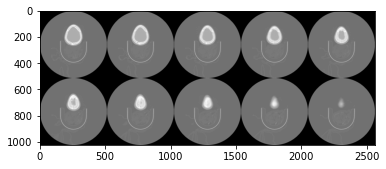

In [43]:
custom_imshow_3d(sitk_image, plane='axial')

### Visualizing results of segmentation and registration -- TODO

# PET data

In [38]:
# PET specific functions

def get_pet_image3d(dicom_slices):
    """
    Input --
    dicom_slices: List of pydicom objects (each is a slice)
    ------
    Output --
    pet_image3d: Numpy array of shape (rows, columns, slices) 
    """
    pet_img_shape = list(dicom_slices[0].pixel_array.shape)
    pet_img_shape.append(len(dicom_slices))
    pet_image3d = np.zeros(pet_img_shape)
    
    # Need slope and intercept to manually rescale pixel values 
    rescale_slope = dicom_slices[0].RescaleSlope
    rescale_intercept = dicom_slices[0].RescaleIntercept
    
    for i, sl in enumerate(dicom_slices):
        image2d = sl.pixel_array
        image2d_rescaled = image2d * rescale_slope + rescale_intercept # Rescale
        pet_image3d[:,:,i] = image2d_rescaled
        
    return pet_image3d
    

In [39]:
pet_series_dir = study_dir + "4.000000-TETECOUAC2D-27812/"


# Pydicom + Numpy style --------------------------------

dicom_slices, n_skipped = read_dicom_slices(pet_series_dir) # Get a list of pydicom objects (slices)
print("Rescale slope:",dicom_slices[0].RescaleSlope)
print("Rescale Intercept:",dicom_slices[0].RescaleIntercept)

# Get a 3D numpy array of pixel values
pet_image3d = get_pet_image3d(dicom_slices)
print(f"Pixel value range: ({pet_image3d.min()}, {pet_image3d.max()})")
plt.imshow(pet_image3d[:,:,80], cmap='gray')

NameError: name 'load_dicom_slices' is not defined

In [ ]:
# SimpleITK style ---------------------------


#TODO

# RTstruct data

In [ ]:
# Plastimatch to convert to sitk supported binary masks (use the script for the data-pipelines repo)